In [1]:
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 10.1 MB/s eta 0:00:00


In [8]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap
import math
import os
import seaborn as sns
import ot
import random
from scipy.stats import multivariate_normal
from random import randint
from pathlib import Path
from mpl_toolkits.axes_grid1 import AxesGrid

print("Packages:");
print("torch.__version__ = " + str(torch.__version__));
print("numpy.__version__ = " + str(np.__version__));
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Packages:
torch.__version__ = 2.3.0+cu121
numpy.__version__ = 1.25.2


In [46]:
# Create neural networks

# Branch and trunk widths respectively
m = 200
m2 = 150

# Branch network, use modified MLP architecture
class Branch_enh(nn.Module):
    def __init__(self):
        super(Branch_enh, self).__init__()
        self.hidden_U = nn.Linear(576,m, bias=True)
        self.hidden_V = nn.Linear(576,m, bias=True)
        self.hidden_H_1 = nn.Linear(576,m, bias=True); self.hidden_Z_1 = nn.Linear(m,m, bias=True)
        self.hidden_Z_2 = nn.Linear(m,m, bias=True); self.hidden_Z_3 = nn.Linear(m,m, bias=True)
        self.hidden_Z_4 = nn.Linear(m,m, bias=True); self.hidden_Z_5 = nn.Linear(m,m, bias=True)
        self.hidden_Z_6 = nn.Linear(m,m, bias=True); self.hidden_Z_7 = nn.Linear(m,800, bias=True)


    def forward(self, u):
        U = F.tanh(self.hidden_U(u)); V = F.tanh(self.hidden_V(u)); H_1 = F.tanh(self.hidden_H_1(u));
        Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
        Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
        Z_3 = F.tanh(self.hidden_Z_3(H_3)); H_4 = (1 - Z_3)*U + Z_3*V
        Z_4 = F.tanh(self.hidden_Z_4(H_4)); H_5 = (1 - Z_4)*U + Z_4*V
        Z_5 = F.tanh(self.hidden_Z_5(H_5)); H_6 = (1 - Z_5)*U + Z_5*V
        Z_6 = F.tanh(self.hidden_Z_6(H_6)); H_7 = (1 - Z_6)*U + Z_6*V
        Z_7 = self.hidden_Z_7(H_7)
        output = Z_7
        return output

# Trunk network, modified MLP architecture
class Trunk_enh(nn.Module):
    def __init__(self):
        super(Trunk_enh, self).__init__()
        self.hidden_U = nn.Linear(3,m2, bias=True)
        self.hidden_V = nn.Linear(3,m2, bias=True)
        self.hidden_H_1 = nn.Linear(3,m2, bias=True); self.hidden_Z_1 = nn.Linear(m2,m2, bias=True)
        self.hidden_Z_2 = nn.Linear(m2,m2, bias=True); self.hidden_Z_3 = nn.Linear(m2,m2, bias=True)
        self.hidden_Z_4 = nn.Linear(m2,m2, bias=True); self.hidden_Z_5 = nn.Linear(m2,m2, bias=True)
        self.hidden_Z_6 = nn.Linear(m2,m2, bias=True); self.hidden_Z_7 = nn.Linear(m2,800, bias=True)


    def forward(self, x,y,t):
        z = torch.cat((x,y,t),1)
        U = F.tanh(self.hidden_U(z)); V = F.tanh(self.hidden_V(z)); H_1 = F.tanh(self.hidden_H_1(z));
        Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
        Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
        Z_3 = F.tanh(self.hidden_Z_3(H_3)); H_4 = (1 - Z_3)*U + Z_3*V
        Z_4 = F.tanh(self.hidden_Z_4(H_4)); H_5 = (1 - Z_4)*U + Z_4*V
        Z_5 = F.tanh(self.hidden_Z_5(H_5)); H_6 = (1 - Z_5)*U + Z_5*V
        Z_6 = F.tanh(self.hidden_Z_6(H_6)); H_7 = (1 - Z_6)*U + Z_6*V
        Z_7 = self.hidden_Z_7(H_7)
        output = Z_7
        return output

In [47]:
# Declare networks
cty_branch0 = Branch_enh().to(device)
cty_branch1 = Branch_enh().to(device)
cty_trunk = Trunk_enh().to(device)

HJ_branch0 = Branch_enh().to(device)
HJ_branch1 = Branch_enh().to(device)
HJ_trunk = Trunk_enh().to(device)

In [ ]:
# Create optimizer
optimizer = optim.Adam([
    {'params': cty_branch0.parameters()},
    {'params': cty_branch1.parameters()},
    {'params': cty_trunk.parameters()},
    {'params': HJ_branch0.parameters()},
    {'params': HJ_branch1.parameters()},
    {'params': HJ_trunk.parameters()},
], lr=3e-5)

In [57]:
# Load saved models if desired

File = "Cty_branch0.pth"
cty_branch0.load_state_dict(torch.load(File))

File = "Cty_branch1.pth"
cty_branch1.load_state_dict(torch.load(File))

File = "Cty_trunk.pth"
cty_trunk.load_state_dict(torch.load(File))

File = "HJ_branch0.pth"
HJ_branch0.load_state_dict(torch.load(File))

File = "HJ_branch1.pth"
HJ_branch1.load_state_dict(torch.load(File))

File = "HJ_trunk.pth"
HJ_trunk.load_state_dict(torch.load(File))

<All keys matched successfully>

In [ ]:
# Define cost functions
mse_cost_function = torch.nn.MSELoss()
l1_cost_function = torch.nn.L1Loss()

In [22]:
# Prepare domain and data

n = 24 # Mesh size in one dimension
N = 200 # Number of initial conditions
N_g = 2000 # Number of random Gaussians to be sampled
x_min = 0
x_max = 5
y_min = 0
y_max = 5
K = 24  # Number of mixtures in u0 and u1 combined
c = 1/6

t0 = torch.zeros(size=(n*n,1)).to(device)
t1 = 1*torch.ones(size=(n*n,1)).to(device)

x = np.linspace(x_min,x_max, n)
y = np.linspace(y_min, y_max, n)
X, Y = np.meshgrid(x, y)
X_vec = torch.unsqueeze(Variable(torch.from_numpy(X.flatten()), requires_grad=True),1).to(device).to(torch.float32)
Y_vec = torch.unsqueeze(Variable(torch.from_numpy(Y.flatten()), requires_grad=True),1).to(device).to(torch.float32)

Omega = np.concatenate([X[:,:,None], Y[:,:,None]], axis=-1)

In [24]:
Gaussian_sample = np.zeros(shape=(N_g,n,n))

for m in range(N_g):

  means = np.random.uniform(low=0.8, high=x_max-0.8, size=(2))
  variances_1 = np.random.uniform(low=0.35, high=0.4, size=(2))
  variances_2 = np.random.uniform(low=0.75, high=0.9, size=(2))
  Sigma = np.random.uniform(low=-0.1, high=0.1, size=(2,2))
  if m % 2 == 0:
    Sigma[0,0] = variances_1[0]
    Sigma[1,1] = variances_1[1]
  else:
    Sigma[0,0] = variances_2[0]
    Sigma[1,1] = variances_2[1]


  Gaussian_sample[m,:,:] = multivariate_normal.pdf(Omega, mean=means[:], cov=Sigma[:,:])

In [37]:
# Construct training data

# Create training data of vectors of each Gaussian mixture
# First dimension is number of training data samples
# Second dimension is nxn = grid length x grid length
u0 = torch.zeros(size=(N,n*n))
u1 = torch.zeros(size=(N,n*n))

for m in range(N):

  # Initialize a grid to store a mixture
  U0 = torch.zeros(size=(n,n))
  U1 = torch.zeros(size=(n,n))

  # Create mixtures from random Gaussians
  for k in range(int(K/2)):
    U0 += Gaussian_sample[np.random.randint(0,N_g,1),:,:].squeeze()
    U1 += Gaussian_sample[np.random.randint(0,N_g,1),:,:].squeeze()

  # Ensure normalized condition
  U0 = U0 / ( torch.sum(U0) * ((x_max-x_min)/n)*((y_max-y_min)/n) )
  U1 = U1 / ( torch.sum(U1) * ((x_max-x_min)/n)*((y_max-y_min)/n) )

  # Flatten for vector input
  u0[m,:] = U0.flatten()
  u1[m,:] = U1.flatten()


u0 = u0.to(device)
u1 = u1.to(device)

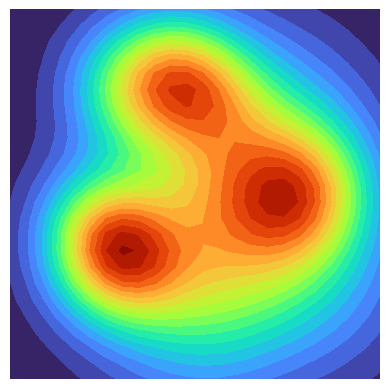

In [38]:
plt.contourf(x,y,U1,20,cmap='turbo')
plt.gca().set_axis_off()
plt.gca().set_aspect('equal', adjustable='box')

In [27]:
print(U1.shape)

torch.Size([1, 24, 24])


In [ ]:
# Save training data if needed
File = "u0.pth"
torch.save(u0, File)

File = "u1.pth"
torch.save(u1, File)

In [ ]:
# Load training data
File = "u0.pth"
u0 = torch.load(File)

File = "u1.pth"
u1 = torch.load(File)

In [ ]:
# Define physics-informed loss for continuity and Hamilton-Jacobi (HJ) equations

def physics_informed_loss(x, y, t, u0, u1, cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk):

  # Evaluate continuity neural networks
  cty_branch0_output = cty_branch0(u0)
  cty_branch1_output = cty_branch1(u1)
  cty_trunk_output = cty_trunk(x, y, t)

  # Formulate continuity enhanced deep operator network
  cty = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output, dim=1)

  # Formulate continuity derivatives
  cty_x = torch.autograd.grad(cty.sum(), x, create_graph=True)[0]
  cty_y = torch.autograd.grad(cty.sum(), y, create_graph=True)[0]
  cty_t = torch.autograd.grad(cty.sum(), t, create_graph=True)[0]
  cty = torch.unsqueeze(cty,1)

  # Evaluate HJ neural networks
  HJ_branch0_output = HJ_branch0(u0)
  HJ_branch1_output = HJ_branch1(u1)
  HJ_trunk_output = HJ_trunk(x, y, t)

  # Formulate HJ enhanced deep operator network
  HJ = torch.sum( (HJ_branch0_output * HJ_branch1_output) * HJ_trunk_output, dim=1)

  # Formulate HJ derivarives
  HJ_x = torch.autograd.grad(HJ.sum(), x, create_graph=True)[0]
  HJ_xx = torch.autograd.grad(HJ_x.sum(), x, create_graph=True)[0]
  HJ_y = torch.autograd.grad(HJ.sum(), y, create_graph=True)[0]
  HJ_yy = torch.autograd.grad(HJ_y.sum(), y, create_graph=True)[0]
  HJ_t = torch.autograd.grad(HJ.sum(), t, create_graph=True)[0]
  HJ = torch.unsqueeze(HJ,1)

  # Formulate physics-informed losses
  cty_loss = (cty_t + cty_x*HJ_x + cty*HJ_xx + cty_y*HJ_y + cty*HJ_yy)**2
  HJ_loss = 0.5*(HJ_t + (1/2)*(HJ_x**2 + HJ_y**2))**2

  # Return sum. Modify coefficients as desired
  return(cty_loss + HJ_loss)

In [ ]:
num_iter = 1000000
batch_size = 2000

T0 = torch.zeros(size=(batch_size,1)).to(device)


for i in range(num_iter):

  # Randomly select indices for batch
  I = np.random.randint(0,N,batch_size)    # index for sample
  J = np.random.randint(0,n*n,batch_size)  # index for  (x,y,t)

  # Collocation prcoedure. Randomly sample x,y,t
  x_unif = Variable(torch.from_numpy(np.random.uniform(x_min,x_max,size=(batch_size,1))).float(), requires_grad=True).to(device)
  y_unif = Variable(torch.from_numpy(np.random.uniform(y_min,y_max,size=(batch_size,1))).float(), requires_grad=True).to(device)
  t_unif = Variable(torch.from_numpy(np.random.uniform(0,1,size=(batch_size,1))).float(), requires_grad=True).to(device)

  # Evaluate continuity equations
  cty_branch0_output = cty_branch0(u0[I,:])
  cty_branch1_output = cty_branch1(u1[I,:])
  cty_trunk_output_0 = cty_trunk(X_vec[J], Y_vec[J], t0[J])
  cty_trunk_output_1 = cty_trunk(X_vec[J], Y_vec[J], t1[J])

  # Formulate enhanced deep operator network output
  inner_prod_0 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_0, dim=1)
  inner_prod_1 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_1, dim=1)

  # Formulate boundary loss
  boundary_loss_0 = mse_cost_function(inner_prod_0, u0[I,J])
  boundary_loss_1 = mse_cost_function(inner_prod_1, u1[I,J])

  # Evaluate physics-informed loss
  physics_term = physics_informed_loss(x_unif, y_unif, t_unif, u0[I,:], u1[I,:], cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk)
  physics_loss = l1_cost_function(physics_term, T0)

  # Total loss. Modify coefficients as desired
  loss = 1*boundary_loss_0  + 1*boundary_loss_1  +  0.5*physics_loss


  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  if i % 100 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data), "PINN loss:", '{:.4e}'.format(physics_loss))

In [ ]:
# Save trained models

File = "Cty_branch0.pth"
torch.save(cty_branch0.state_dict(), File)

File = "Cty_branch1.pth"
torch.save(cty_branch1.state_dict(), File)

File = "Cty_trunk.pth"
torch.save(cty_trunk.state_dict(), File)

File = "HJ_branch0.pth"
torch.save(HJ_branch0.state_dict(), File)

File = "HJ_branch1.pth"
torch.save(HJ_branch1.state_dict(), File)

File = "HJ_trunk.pth"
torch.save(HJ_trunk.state_dict(), File)

In [51]:
# Get test results

n = 24 # Base resolution mesh size
x = np.linspace(x_min,x_max, n)
y = np.linspace(y_min, y_max, n)
X, Y = np.meshgrid(x, y)
Omega = np.concatenate([X[:,:,None], Y[:,:,None]], axis=-1)

# Create domain for high resolution data
n_h = 40     # High resolution mesh size for super resolution
x_h = np.linspace(x_min,x_max, n_h)
y_h = np.linspace(y_min, y_max, n_h)
X_h, Y_h = np.meshgrid(x_h, y_h)
X_h_vec = torch.unsqueeze(Variable(torch.from_numpy(X_h.flatten()), requires_grad=True),1).to(device).to(torch.float32)
Y_h_vec = torch.unsqueeze(Variable(torch.from_numpy(Y_h.flatten()), requires_grad=True),1).to(device).to(torch.float32)
Omega_h = np.concatenate([X_h[:,:,None], Y_h[:,:,None]], axis=-1)

In [62]:
values = np.linspace(0, 1, 10)
turbo_cmap = plt.get_cmap('turbo')
colors = [turbo_cmap(value) for value in values]

In [52]:
def heatmap2d_grid(U: np.ndarray):
    cmap = LinearSegmentedColormap.from_list('Colormap', [colors[0], colors[0], colors[0], colors[1], colors[2], colors[3], colors[4], colors[5], colors[6], colors[7], colors[8], colors[9]])

    # Plot the geodesics at the five times
    fig, axes = plt.subplots(1, 5, figsize=(12, 2))

    for i, ax in enumerate(axes):
        ax.contourf(x_h, y_h, U[i, :, :], 15, cmap=cmap)
        ax.set(xticklabels=[], yticklabels=[])
        ax.tick_params(left=False, bottom=False)
        ax.set_aspect('equal', adjustable='box')

    plt.savefig('Pred_geodesic.png', dpi=350)

    plt.xticks([])
    plt.yticks([])

    plt.show()

In [89]:
K = 24 # number of total Gaussians in the mixture pair u0, u1

# Create means and variances
means = np.random.uniform(low=0.8, high=x_max-0.8, size=(K,2))
variances_1 = np.random.uniform(low=0.35, high=0.4, size=(K,2))
variances_2 = np.random.uniform(low=0.75, high=0.9, size=(K,2))
covariances = np.random.uniform(low=-0.1, high=0.1, size=(K,2))
Sigma = np.zeros(shape=(2,2,K))

for i in np.arange(0,K,2):
  Sigma[0,0,i] = variances_1[i,0]; Sigma[1,1,i] = variances_1[i,1]
  Sigma[0,1,i] = covariances[i,0]; Sigma[1,0,i] = covariances[i,1]
for i in np.arange(1,K+1,2):
  Sigma[0,0,i] = variances_2[i,0]; Sigma[1,1,i] = variances_2[i,1]
  Sigma[0,1,i] = covariances[i,0]; Sigma[1,0,i] = covariances[i,1]

U0 = torch.zeros(size=(n,n))
U1 = torch.zeros(size=(n,n))
U0_h = torch.zeros(size=(n_h,n_h))
U1_h = torch.zeros(size=(n_h,n_h))
u0_test = torch.zeros(size=(1,n*n)).to(device)
u1_test = torch.zeros(size=(1,n*n)).to(device)

for i in range(int(K/2)):
  U0 += multivariate_normal.pdf(Omega, mean=means[i,:], cov=Sigma[:,:,i])
  U1 += multivariate_normal.pdf(Omega, mean=means[i+int(K/2),:], cov=Sigma[:,:,i+int(K/2)])

  U0_h += multivariate_normal.pdf(Omega_h, mean=means[i,:], cov=Sigma[:,:,i])
  U1_h += multivariate_normal.pdf(Omega_h, mean=means[i+int(K/2),:], cov=Sigma[:,:,i+int(K/2)])


# Ensure normalized condition on neural network input
U0 = U0 / ( torch.sum(U0) * ((x_max-x_min)/n)*((y_max-y_min)/n) )
U1 = U1 / ( torch.sum(U1) * ((x_max-x_min)/n)*((y_max-y_min)/n) )

# Ensure normalized condition on high resolution data
U0_h = U0_h/ ( torch.sum(U0_h) * ((x_max-x_min)/n)*((y_max-y_min)/n) )
U1_h = U1_h / ( torch.sum(U1_h) * ((x_max-x_min)/n)*((y_max-y_min)/n) )


u0_test[0,:] = U0.flatten()
u1_test[0,:] = U1.flatten()

In [90]:
# Get visual results on test data
T = 5
u_test = torch.zeros(size=(T,n_h*n_h))
u_test_reshape = torch.zeros(size=(T,n_h,n_h))

cty_branch0_output_test = cty_branch0(u0_test[0,:])
cty_branch1_output_test = cty_branch1(u1_test[0,:])
for t in range(T):
  T_test = (t/(T-1))*torch.ones(size=(n_h*n_h,1)).to(device)
  cty_trunk_output_test = cty_trunk(X_h_vec, Y_h_vec, T_test)
  u_test[t,:] = torch.sum( (cty_branch0_output_test * cty_branch1_output_test) * cty_trunk_output_test, dim=1)
  u_test_reshape[t,:,:] = torch.reshape(u_test[t,:], (n_h,n_h))

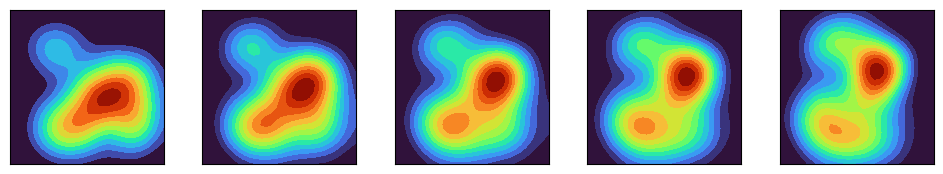

In [91]:
heatmap2d_grid(u_test_reshape[:,:,:].cpu().detach().numpy())

In [92]:
# Get POT results

# Input data for POT. Scale as necessary
f1 = U0_h.cpu().detach().numpy(); f2 = U1_h.cpu().detach().numpy(); f3 = np.ones(shape=(n_h,n_h)); f4 = np.ones(shape=(n_h,n_h))
f1 = ((n_h/5)**2)*f1 / np.sum(f1); f2 = ((n_h/5)**2)*f2 / np.sum(f2); f3 = ((n_h/5)**2)*f3 / np.sum(f3); f4 = ((n_h/5)**2)*f4 / np.sum(f4)

# Additional input
A = np.array([f1, f2, f3, f4])
nb_images = 5
v1 = np.array((1, 0, 0, 0)); v2 = np.array((0, 1, 0, 0)); v3 = np.array((0, 0, 1, 0)); v4 = np.array((0, 0, 0, 1))
OT = np.zeros(shape=(nb_images,nb_images,n_h,n_h))


reg = 0.004 # Regularization constant
for i in range(nb_images):
    for j in range(nb_images):
        tx = float(i) / (nb_images - 1); ty = float(j) / (nb_images - 1)
        tmp1 = (1 - tx) * v1 + tx * v2; tmp2 = (1 - tx) * v3 + tx * v4; weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            OT[i,j,:,:] = f1
        elif i == 0 and j == (nb_images - 1):
            OT[i,j,:,:] = f3
        elif i == (nb_images - 1) and j == 0:
            OT[i,j,:,:] = f2
        elif i == (nb_images - 1) and j == (nb_images - 1):
            OT[i,j,:,:] = f4
        else:
            OT[i,j,:,:] = ot.bregman.convolutional_barycenter2d(A, reg, weights)

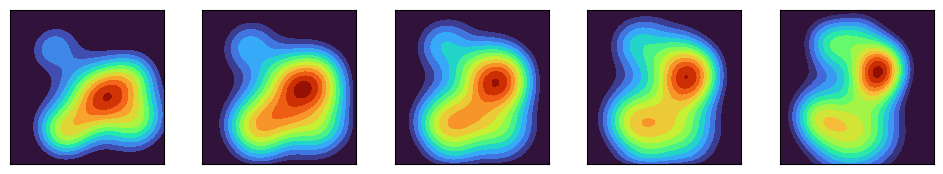

In [93]:
heatmap2d_grid(OT[:,0,:,:])

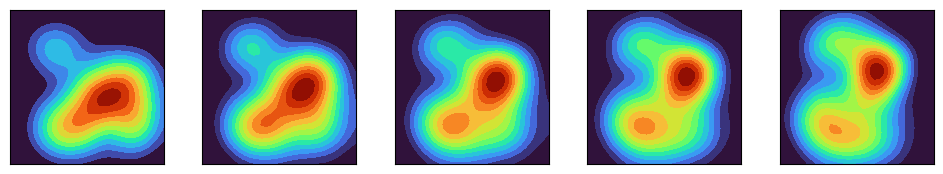

In [94]:
heatmap2d_grid(u_test_reshape[:,:,:].cpu().detach().numpy())